# Country Analysis: Comparative Analysis Using Frequency

## Table of Contents
- [1. Getting the data](#one)
- [2. Preparing the data](#two)
- [3. PCA Analysis](#three)
- [4. t-SNE Implementation](#four)
    - [4.1. Fixed perplexity](#four-one)
    - [4.2. Effects of perplexity](#four-two)
- [5. Hierarchical Clustering](#five)

## 1. Getting the data <a class="anchor" id="one"></a>

In [1]:
import py2neo
import pandas
import numpy
import scipy.linalg
import matplotlib.pyplot
import sklearn.manifold
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy 
import math
from scipy import cluster

%matplotlib inline
numpy.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [2]:
local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = py2neo.Graph(local_connection_url)

Getting the name of all of the terms. 

In [3]:
def get_terms(processVariableType):
    query = """  MATCH (a:Asset)-[:CONTAINS]->(pv:{})
                 RETURN pv.term, count(pv)""".format(processVariableType)
    
    names = sorted(list(set(pandas.DataFrame(connection_to_graph.data(query)).as_matrix()[:, 1])))
    
    return names

In [4]:
process_variables_names =  {
            'Feedstock':get_terms('Feedstock'),
            'ProcessingTech':get_terms('ProcessingTech'),
            'Output':get_terms('Output'),        
        }

Getting the name of all of the countries

In [5]:
def get_countries():
    query = """ MATCH (c:Country)
                RETURN c.name"""
    
    names = sorted(list(set(pandas.DataFrame(connection_to_graph.data(query)).as_matrix()[:, 0])))
    
    return names    

In [6]:
country_names = get_countries()

Getting Occurences for any country and process variable-

In [7]:
def get_pv_contry(country, processVariable):
    
    """
    Receives a country and a processVariable and returns the occurences of the various terms in that process variable for a given country. 
    """
    
    q = """ MATCH (a:Asset)-[:CONTAINS]->(pv:{})
            WHERE a.country CONTAINS  "{}"
            RETURN pv.term, count(pv)""".format(processVariable, country)
    
    data = pandas.DataFrame(connection_to_graph.data(q)).as_matrix()
    
    country_occurences = [0] * len(process_variables_names[processVariable])
    
    if len(data) == 0:
        return country_occurences
    
    for index1, name in enumerate(process_variables_names[processVariable]):
        for index2, data_name in enumerate(data[:, 1]):
            if name == data_name:
                country_occurences[index1] = data[index2, 0]
    
    
    return country_occurences

Matrix of Feedstocks

In [8]:
def get_matrix(process_type):
    matrix = numpy.zeros((len(country_names), len(process_variables_names[process_type])))
    row = 0
    
    for country in country_names:
        matrix[row, :] = get_pv_contry(country, process_type)
        row += 1
        
    return matrix    

In [9]:
feed_matrix = get_matrix('Feedstock')

Matrix of Processing Technologies

In [10]:
proc_matrix = get_matrix('ProcessingTech')

Matrix of Outputs

In [11]:
out_matrix = get_matrix('Output')

Robustness Check

In [12]:
country = 'Denmark'
index = country_names.index(country)
print get_pv_contry(country, 'Output') == out_matrix[index, :]

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


## 2. Preparing the data <a class="anchor" id="two"></a>

Definning our X matrix. Here, every row will correspond to a country, and every column to a particular term. 

In [13]:
X = numpy.hstack((feed_matrix,proc_matrix, out_matrix))
print 'Shape of X is: ', X.shape

Shape of X is:  (145, 352)


Let us clean the countries that have absolutely no documents. 

In [14]:
print 'These have no docs:'
no_docs = [i for i in range(len(numpy.sum(X, axis=1))) if numpy.sum(X, axis=1)[i] == 0]
print [country_names[i] for i in no_docs]

These have no docs:
[u'Armenia', u'Central African Republic', u'Falkland Islands', u'Georgia', u'Libya', u'Panama', u'Togo', u'Venezuela']


We delete these countries (or rows) from our matrix X and from our list of country names.  

In [15]:
X = numpy.delete(X, no_docs, 0)
country_names = list(numpy.delete(country_names, no_docs))

We normalize by row and then standardize our dataset. 

In [16]:
X = X/X.sum(axis=1, keepdims=True)
X = (X - numpy.mean(X)) / numpy.std(X)

print 'Shape of X is: ', X.shape

Shape of X is:  (137, 352)


Let us then define the countries that we want to highlight during the analysis. To add a marker in the future. 

In [17]:
interesting_countries = ['Denmark', 'Sweden', 'Norway', 'Finland', 'Netherlands', 'Germany']
idx = idxs = [country_names.index(e) for e in interesting_countries]

## 3. PCA Analysis <a class="anchor" id="three"></a>

Variance Explained by Principal Components

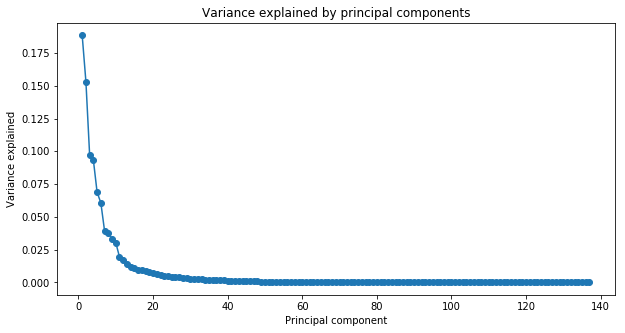

In [18]:

# PCA by computing SVD of Y
U,S,V = scipy.linalg.svd(X,full_matrices=False)

# Compute variance explained by principal components
rho = (S*S) / (S*S).sum()

# Amounts of Variation
variation = range(1,len(rho)+1)
count = 0
amount = 0

# Plot variance explained
matplotlib.pyplot.subplots(1,1,figsize=(10, 5))
matplotlib.pyplot.plot(range(1,len(rho)+1),rho,'o-')
matplotlib.pyplot.title('Variance explained by principal components')
matplotlib.pyplot.xlabel('Principal component')
matplotlib.pyplot.ylabel('Variance explained')
matplotlib.pyplot.show()

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


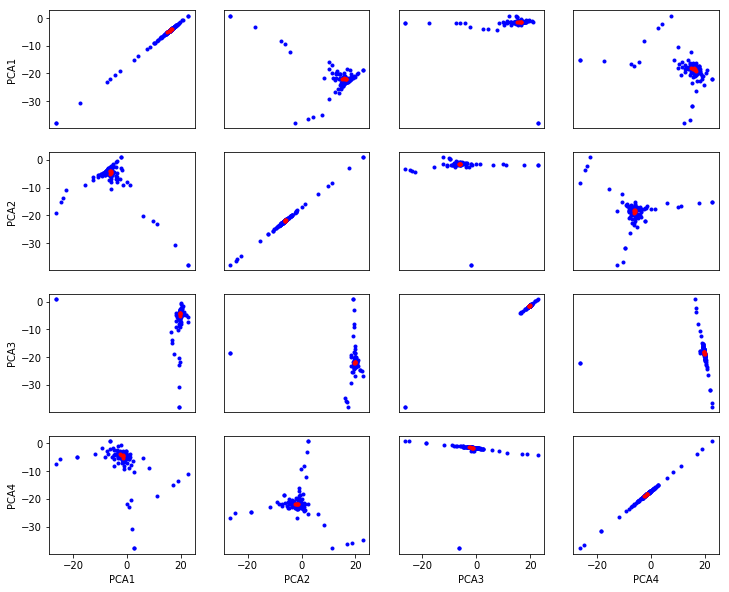

In [19]:
VT = V.T
Y = X
Z = numpy.dot(Y, VT)

# Number of PCAS to plot
k = 4

matplotlib.pyplot.figure(figsize=(12,10))
matplotlib.pyplot.hold(True)
for i in range(k):
    for j in range(k):
        matplotlib.pyplot.subplot(k, k, i*k + j + 1)
        
        matplotlib.pyplot.plot(Z[:, i], Z[:, j], '.', c='b')
        matplotlib.pyplot.plot(Z[idxs, i], Z[idxs, j], '.', c='r')
        if i==k-1:
            matplotlib.pyplot.xlabel('PCA{}'.format(j+1), fontsize=10)
        else:
            matplotlib.pyplot.xticks([])
        if j==0:
            matplotlib.pyplot.ylabel('PCA{}'.format(i+1), fontsize=10)
        else:
            matplotlib.pyplot.yticks([])


matplotlib.pyplot.show()

## 4. T-SNE Algorythm Implementation <a class="anchor" id="four"></a>

### 4.1. Fixed Perplexity <a class="anchor" id="four-one"></a>

Let us implement the T-SNE Algorithm. We will use 2 components at first for 2D visualization of the data.

In [20]:
n_components = 2
perplexity = 30
n_iter = 5000

tsne = sklearn.manifold.TSNE(n_components=n_components, init='random',random_state=0, perplexity=perplexity, n_iter=n_iter)

We fit X to the algorithm. 

In [21]:
X_embedded = tsne.fit_transform(X)

We plot the results for 2 components (2D).

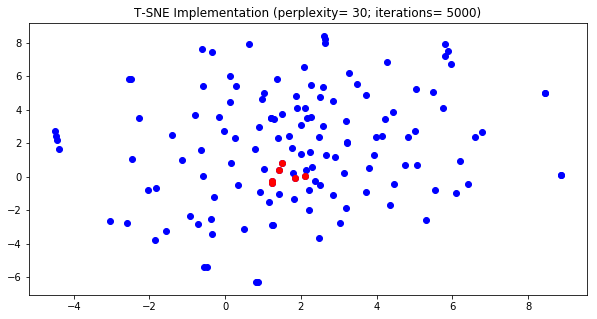

In [22]:
matplotlib.pyplot.subplots(1,1,figsize=(10, 5))
matplotlib.pyplot.scatter(X_embedded[:, 0], X_embedded[:, 1], c='b')
matplotlib.pyplot.scatter(X_embedded[idxs, 0], X_embedded[idxs, 1], c='r')
matplotlib.pyplot.title('T-SNE Implementation (perplexity= {}; iterations= {})'.format(perplexity, n_iter))
matplotlib.pyplot.show()

And for 3 components (3D).

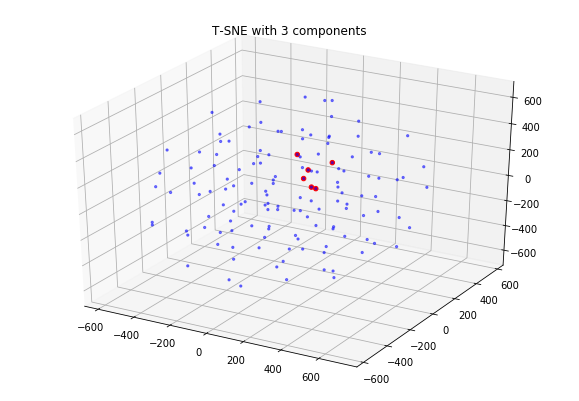

In [23]:
n_components = 3

tsne = sklearn.manifold.TSNE(n_components=n_components, init='random',random_state=0, perplexity=perplexity, n_iter=n_iter)
X_3d_embedded = tsne.fit_transform(X)


fig = matplotlib.pyplot.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

xs = X_3d_embedded[:, 2]
ys = X_3d_embedded[:, 1]
zs = X_3d_embedded[:, 0]

xs_int = X_3d_embedded[idxs, 2]
ys_int = X_3d_embedded[idxs, 1]
zs_int = X_3d_embedded[idxs, 0]

ax.scatter(xs, ys, zs, c='b', marker='.', alpha=0.5)
ax.scatter(xs_int, ys_int, zs_int, c='r', marker='o', alpha=1.0)
ax.set_title('T-SNE with 3 components')

matplotlib.pyplot.show()

However, it is known that in the tsne algorithm, the chosing of the value of `perplexity` can have ramifications in terms of the output. Therefore, we will now try severall different values. 

### 4.2. Effects of perplexity <a class="anchor" id="four-two"></a>

As you might have noticed, we have used a single value for number of iterations (5000), and we will try different values for perplexity. This is because of the information provided in [this](https://distill.pub/2016/misread-tsne/) guide. The author states that 5000 iterations are normally enough, but that perplexity might have an impact on visualizations, hence this chapter. 

In [24]:
perplexities = [2, 5, 30, 50, 100]

Let us plot all of the possibilities. 

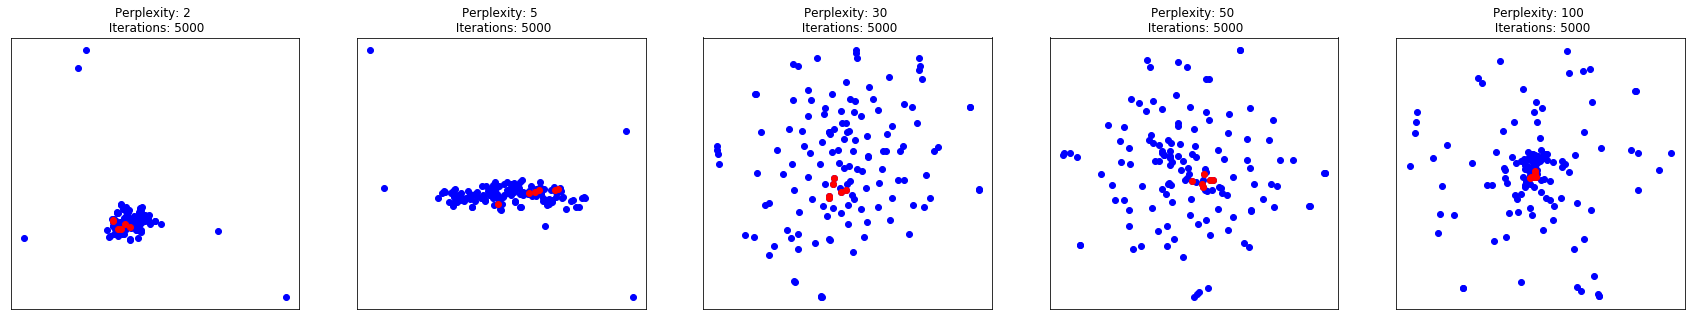

In [25]:
fig, axs = matplotlib.pyplot.subplots(1, len(perplexities), figsize=(30, 5))
for i in range(len(perplexities)):
    tsne = sklearn.manifold.TSNE(n_components=2, init='random',random_state=0, perplexity=perplexities[i], n_iter=5000)
    X_embedded = tsne.fit_transform(X)
    axs[i].scatter(X_embedded[:, 0], X_embedded[:, 1], c='b')
    axs[i].scatter(X_embedded[idxs, 0], X_embedded[idxs, 1], c='r')
    axs[i].set_title('Perplexity: {} \n Iterations: {}'.format(perplexities[i], n_iter))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
matplotlib.pyplot.show()

The effect here is noticeable.

## 5. Hierarchical Clustering <a class="anchor" id="five"></a>

Let us start by plotting the first two attributes of our matrix.

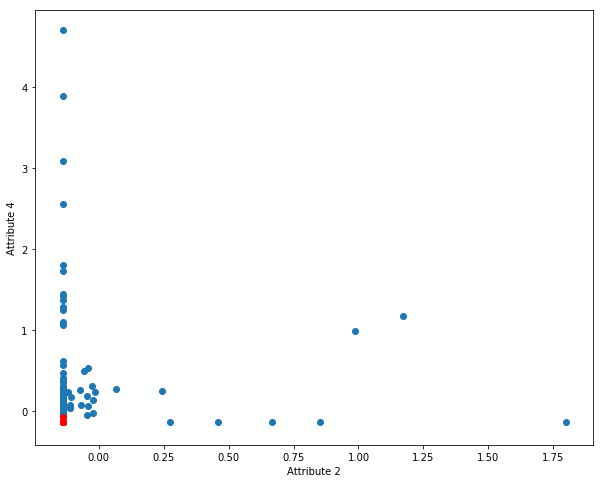

In [26]:
first_attribute = 2
second_attribute = 4

plt.figure(figsize=(10, 8))
plt.scatter(X[:,first_attribute], X[:,second_attribute])  # plot all points
plt.scatter(X[idxs,0], X[idxs,1], c='r')  # plot interesting points in red again
plt.xlabel('Attribute {}'.format(first_attribute))
plt.ylabel('Attribute {}'.format(second_attribute))
plt.show()

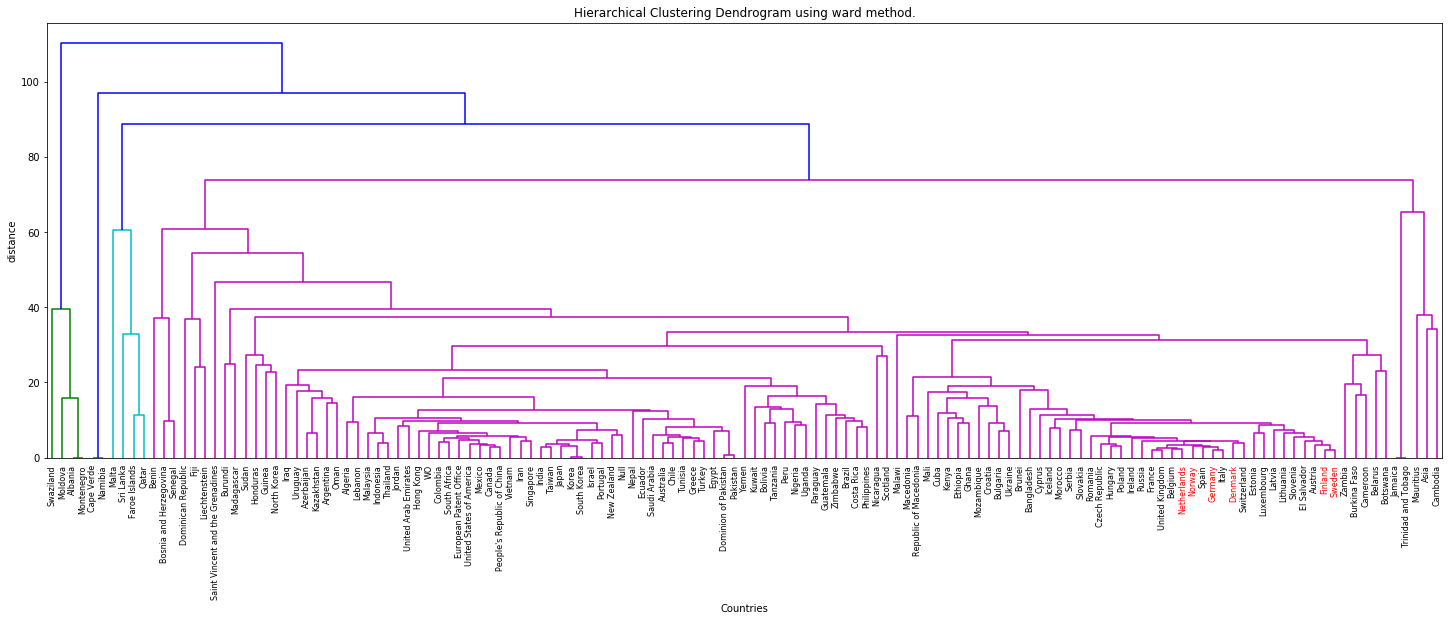

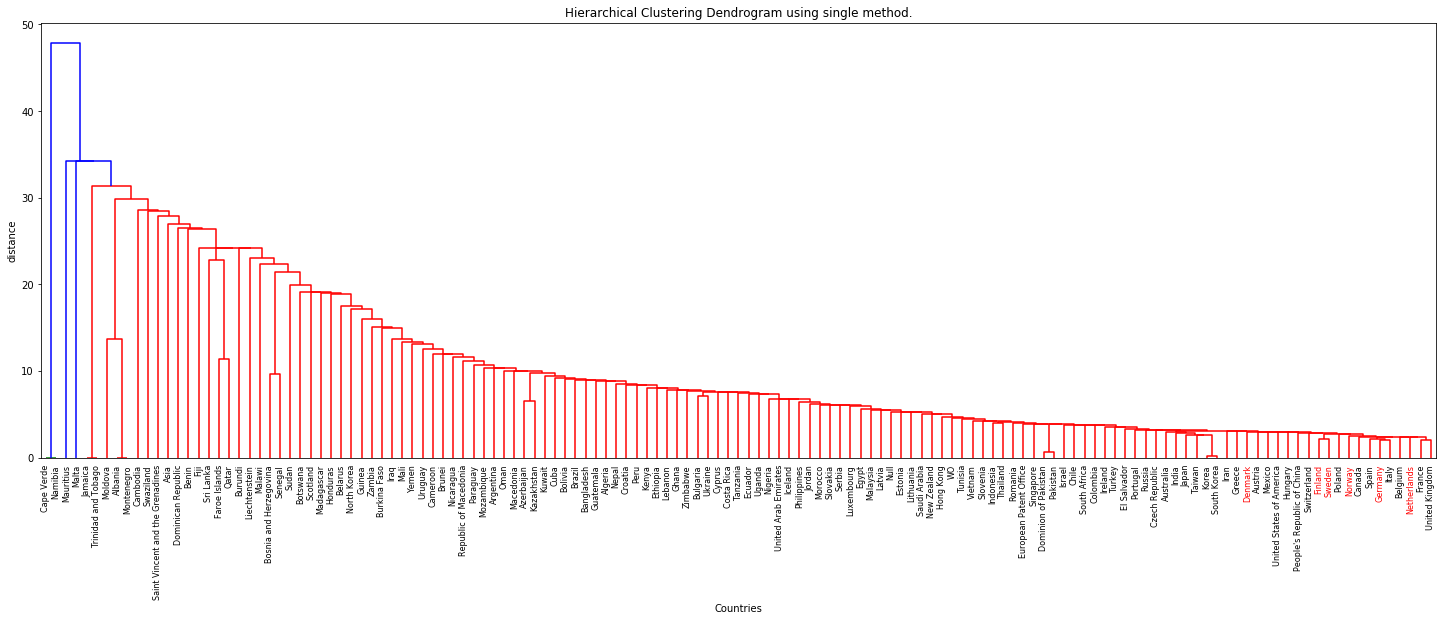

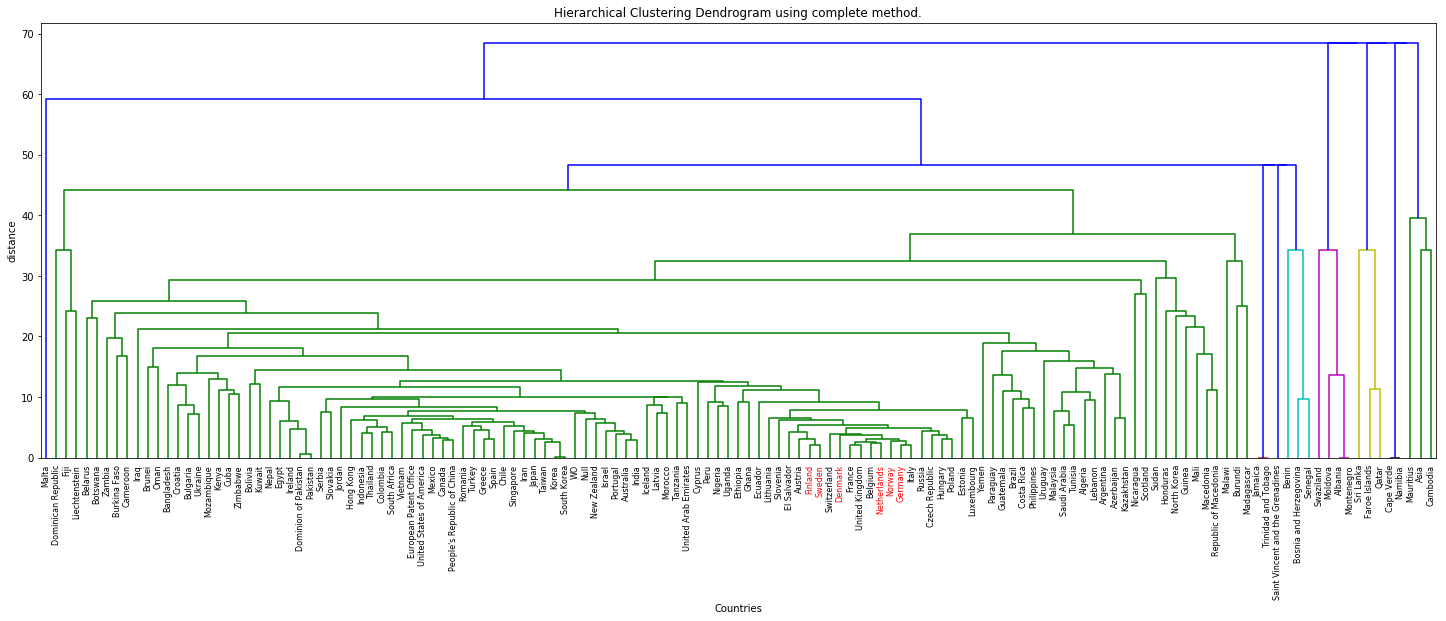

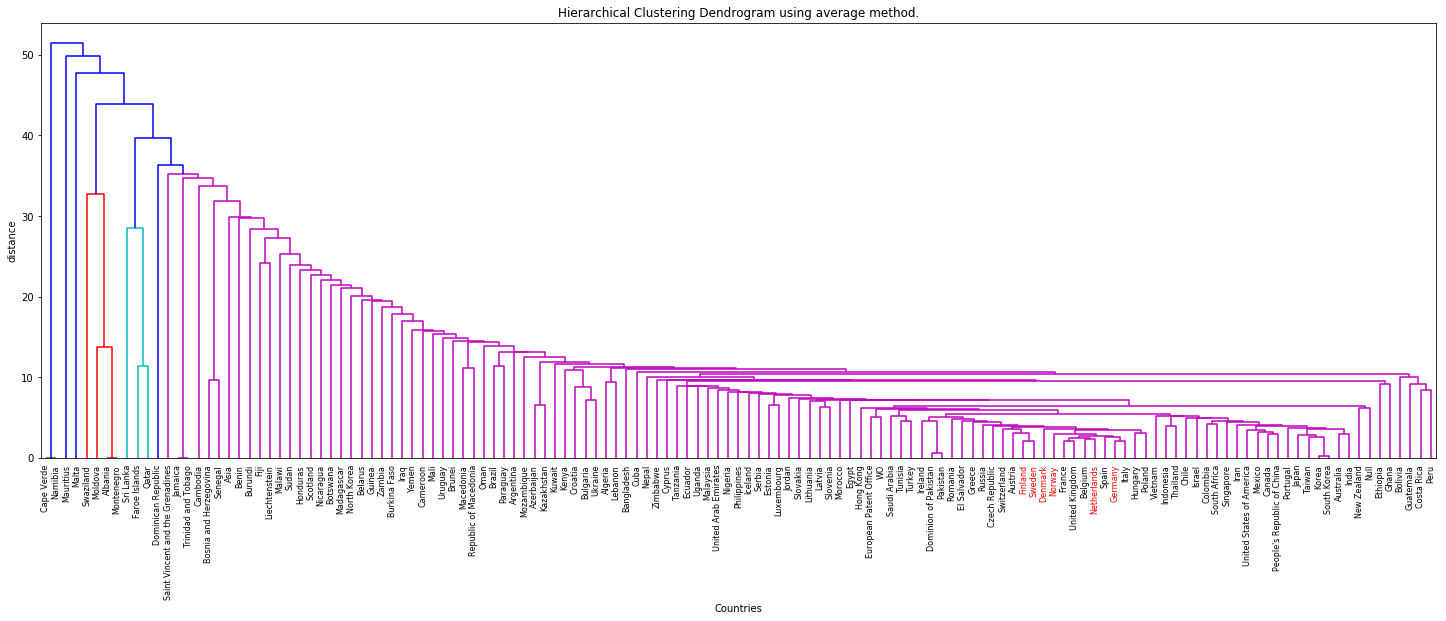

In [27]:
clustering_methods = ['ward', 'single', 'complete', 'average']

for clustering_method in clustering_methods:
    
    Z = scipy.cluster.hierarchy.linkage(X, clustering_method)
    
    plt.figure(figsize=(25, 8))
    plt.title('Hierarchical Clustering Dendrogram using {} method.'.format(clustering_method))
    plt.xlabel('Countries')
    plt.ylabel('distance')
    scipy.cluster.hierarchy.dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        labels = country_names
    )
    
    
    # Assignment of colors to labels: 'a' is red, 'b' is green, etc.
    my_label_colors = {}

    for name in country_names:
        if name in interesting_countries:
            my_label_colors[name] = 'r'
        else:
            my_label_colors[name] = 'black'


    ax = plt.gca()
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(my_label_colors[lbl.get_text()])
    
    plt.show()

## Plotly viz

In [28]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from plotly.graph_objs import *



tsne = sklearn.manifold.TSNE(n_components=2, init='random',random_state=0, perplexity=5, n_iter=5000)
X_embedded = tsne.fit_transform(X)

x = X_embedded[:, 0]
y = X_embedded[:, 1]
xi = X_embedded[idxs, 0]
yi = X_embedded[idxs, 1]

data = [Scatter(x=x, 
               y=y,
               text = country_names,
               mode='markers',
               name='Rest of the world',
               marker=Marker(color='blue', size=6, opacity=0.3)
              ), 
      Scatter(x=xi, 
               y=yi,
               text = interesting_countries,
               mode='markers', 
              name='Countries in Focus',
               marker=Marker(color='red', size=9, opacity=1))]

layout = dict(title = 'T-SNE (perplexity:{}, iterations:{})'.format(perplexity, n_iter),
              yaxis = dict(zeroline = False, showgrid=False, ticks='', showticklabels=False),
              xaxis = dict(zeroline = False, showgrid=False, ticks='', showticklabels=False)
             )

fig = dict(data=data, layout=layout)


iplot(fig,show_link=True)

## 5. Implementation with GDP per capita as evidence <a class="anchor" id="five"></a>

In [29]:
data = pandas.read_csv('Data/GDP_per_capita-Freq.csv', delimiter=';', header=None).as_matrix()
print 'Countries that do not have data:'
countries_with_gdp_data = []
countries_to_delete = []

for country in country_names:
    if country not in data[:, 0]:
        print country
        countries_to_delete.append(country)
    else:
        countries_with_gdp_data.append(country) 

Countries that do not have data:
Asia
Null


In [30]:
for country in countries_with_gdp_data:
    index = list(data[:, 0]).index(country)
    gdp = data[:, 1][index]
    if math.isnan(gdp):
        print country, ' has no value for GDP.'
        countries_to_delete.append(country)
    else:
        continue

Cuba  has no value for GDP.
Faroe Islands  has no value for GDP.
Korea  has no value for GDP.
Liechtenstein  has no value for GDP.
North Korea  has no value for GDP.


In [31]:
print X.shape
print len(country_names)

(137, 352)
137


In [32]:
indexes_to_delete = [country_names.index(country) for country in countries_to_delete]
print indexes_to_delete

[3, 91, 27, 39, 64, 68, 89]


In [33]:
X_gdp = numpy.delete(X, indexes_to_delete, 0)
country_names_gdp = list(numpy.delete(country_names, indexes_to_delete))
list_of_gdp_values = [data[:, 1][list(data[:, 0]).index(country)] for country in country_names_gdp]

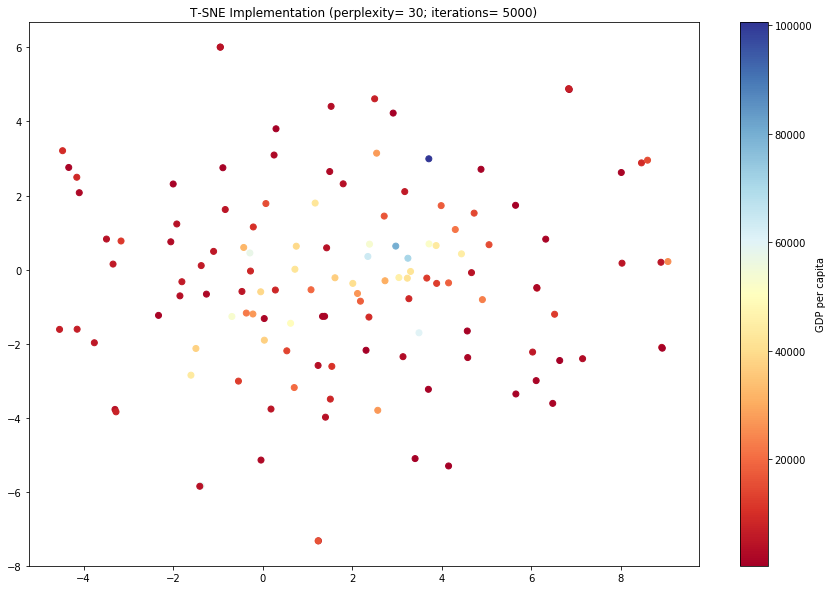

In [34]:
n_components = 2
perplexity = 30
n_iter = 5000

tsne = sklearn.manifold.TSNE(n_components=n_components, init='random',random_state=0, perplexity=perplexity, n_iter=n_iter)
X_embedded = tsne.fit_transform(X_gdp)

matplotlib.pyplot.subplots(1,1,figsize=(15, 10))
cm = plt.cm.get_cmap('RdYlBu')
plot = plt.scatter(X_embedded[:, 0], X_embedded[:, 1],c=list_of_gdp_values, cmap=cm)

plt.title('T-SNE Implementation (perplexity= {}; iterations= {})'.format(perplexity, n_iter))
cb = plt.colorbar(plot)
cb.set_label('GDP per capita')
plt.show()

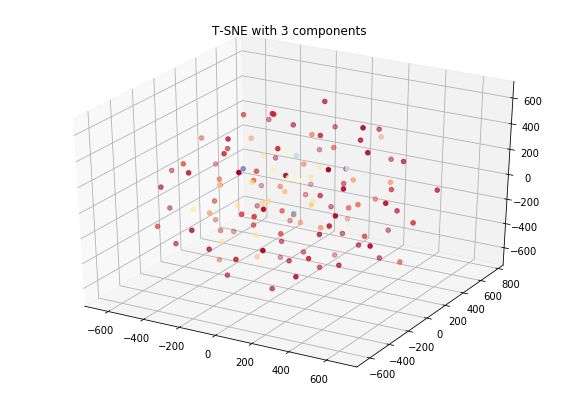

In [35]:
n_components = 3

tsne = sklearn.manifold.TSNE(n_components=n_components, init='random',random_state=0, perplexity=perplexity, n_iter=n_iter)
X_3d_embedded = tsne.fit_transform(X_gdp)


fig = matplotlib.pyplot.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

xs = X_3d_embedded[:, 2]
ys = X_3d_embedded[:, 1]
zs = X_3d_embedded[:, 0]


cm = plt.cm.get_cmap('RdYlBu')
ax.scatter(xs, ys, zs, marker='o', c=list_of_gdp_values, cmap=cm)

ax.set_title('T-SNE with 3 components')

matplotlib.pyplot.show()

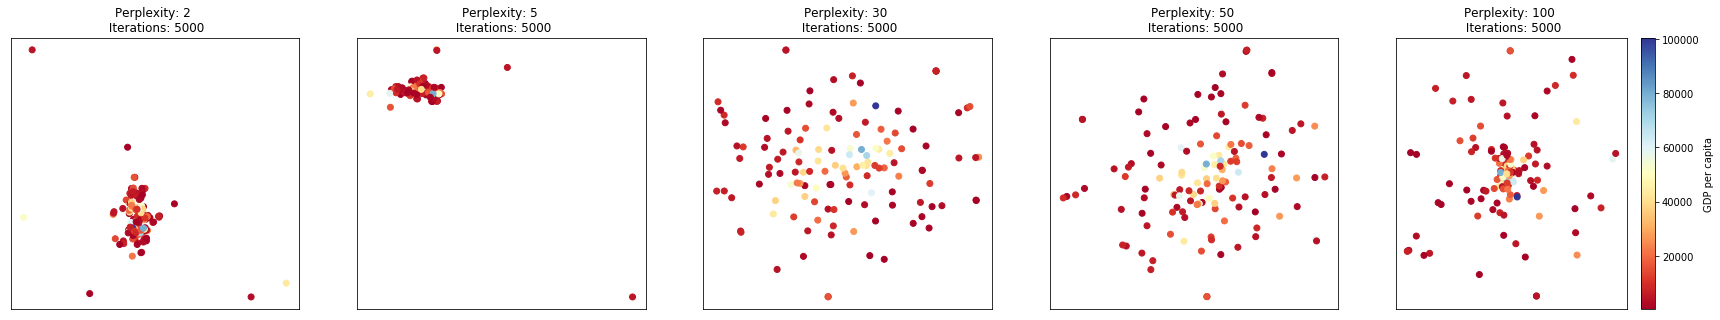

In [36]:
perplexities = [2, 5, 30, 50, 100]
#perplexities = [2, 5]


fig, axs = matplotlib.pyplot.subplots(1, len(perplexities), figsize=(30, 5))
for i in range(len(perplexities)):
    tsne = sklearn.manifold.TSNE(n_components=2, init='random',random_state=0, perplexity=perplexities[i], n_iter=5000)
    X_embedded = tsne.fit_transform(X_gdp)
    cm = plt.cm.get_cmap('RdYlBu')
    plot = axs[i].scatter(X_embedded[:, 0], X_embedded[:, 1], c=list_of_gdp_values, cmap=cm)
    axs[i].set_title('Perplexity: {} \n Iterations: {}'.format(perplexities[i], n_iter))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
    
cb = plt.colorbar(plot)
cb.set_label('GDP per capita')
matplotlib.pyplot.show()

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning:

pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.



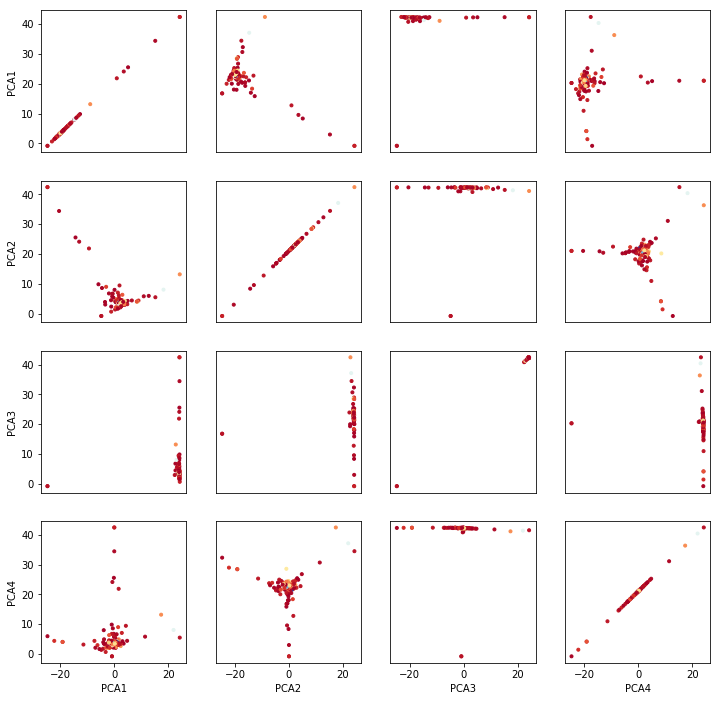

In [37]:
# PCA by computing SVD of Y
U,S,V = scipy.linalg.svd(X_gdp,full_matrices=False)
VT = V.T
Y = X_gdp
Z = numpy.dot(Y, VT)

# Number of PCAS to plot
k = 4

plt.figure(figsize=(12,12))
plt.hold(True)
for i in range(k):
    for j in range(k):
        matplotlib.pyplot.subplot(k, k, i*k + j + 1)
        cm = plt.cm.get_cmap('RdYlBu')
        plot = plt.scatter(Z[:, i], Z[:, j],c=list_of_gdp_values, cmap=cm, marker='.')
        
        if i==k-1:
            plt.xlabel('PCA{}'.format(j+1), fontsize=10)
        else:
            plt.xticks([])
        if j==0:
            plt.ylabel('PCA{}'.format(i+1), fontsize=10)
        else:
            plt.yticks([])


plt.show()




## 6. Compare Clusters <a class="anchor" id="five"></a>

In [38]:
def plot_dendogram(matrix, labels, method, name):
    """
    Function takes a matrix, plots the dedogram and returns the clusters.
    """
    
    Z = scipy.cluster.hierarchy.linkage(matrix, method)
        
    plt.figure(figsize=(25, 8))
    plt.title('Hierarchical Clustering Dendrogram using {} method. {}'.format(clustering_method, name))
    plt.xlabel('Countries')
    plt.ylabel('distance')
    scipy.cluster.hierarchy.dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        labels = labels)
    
    plt.show()
    
    return Z

In [39]:
def return_cluster(dendogram, country_of_interest, max_group_size, labels):
    """
    Returns the cluster of the country of interest as soon as the number of countries in the cluster are smaller than the max group_size
    """
    
    for k in range(150):
        cutree = cluster.hierarchy.cut_tree(dendogram, n_clusters=k)
        country_of_interest = country_of_interest
        index_of_interest =  labels.index(country_of_interest)
        cluster_of_interest = cutree[index_of_interest][0]
        countries_in_cluster_of_interest = []
        
        for i in range(len(cutree)):
            cluster_number = cutree[i][0]
            country_name = labels[i]
            if cluster_number == cluster_of_interest:
                countries_in_cluster_of_interest.append(country_name)
        if len(countries_in_cluster_of_interest) < group_size:
            break
            
    return countries_in_cluster_of_interest

In [40]:
# define mclustering method and country of interest.
method = 'average'
country_of_interest = 'Denmark'
group_size = 20

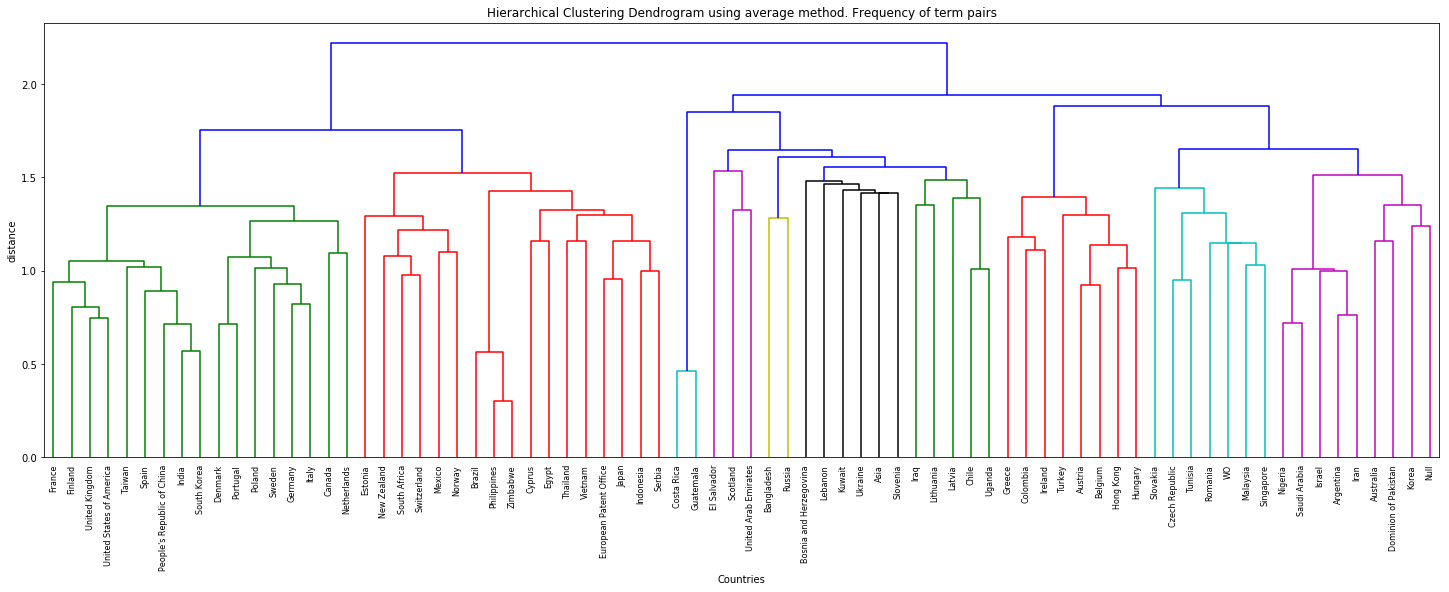

Cluster of Denmark:
[u'Canada', u'Denmark', u'Finland', u'France', u'Germany', u'India', u'Italy', u'Netherlands', u"People's Republic of China", u'Poland', u'Portugal', u'South Korea', u'Spain', u'Sweden', u'Taiwan', u'United Kingdom', u'United States of America']


In [41]:
# plot the map and cluster of the country of interest using term pair frequency
matrix = numpy.load('Data/correlation_matrix.npy')
labels = list(numpy.load('Data/correlation_matrix_names.npy'))

name = 'Frequency of term pairs'

Z = plot_dendogram(matrix=matrix, labels=labels, method=method, name=name)
print 'Cluster of {}:'.format(country_of_interest)
print return_cluster(dendogram=Z, country_of_interest=country_of_interest, max_group_size=group_size, labels=labels)

In [42]:
# delete countries that are not in original list.
this_list = country_names
original_list = list(numpy.load('Data/correlation_matrix_names.npy'))
to_delete = []

for i in range(len(this_list)):
    if this_list[i] not in original_list:
        to_delete.append(i)


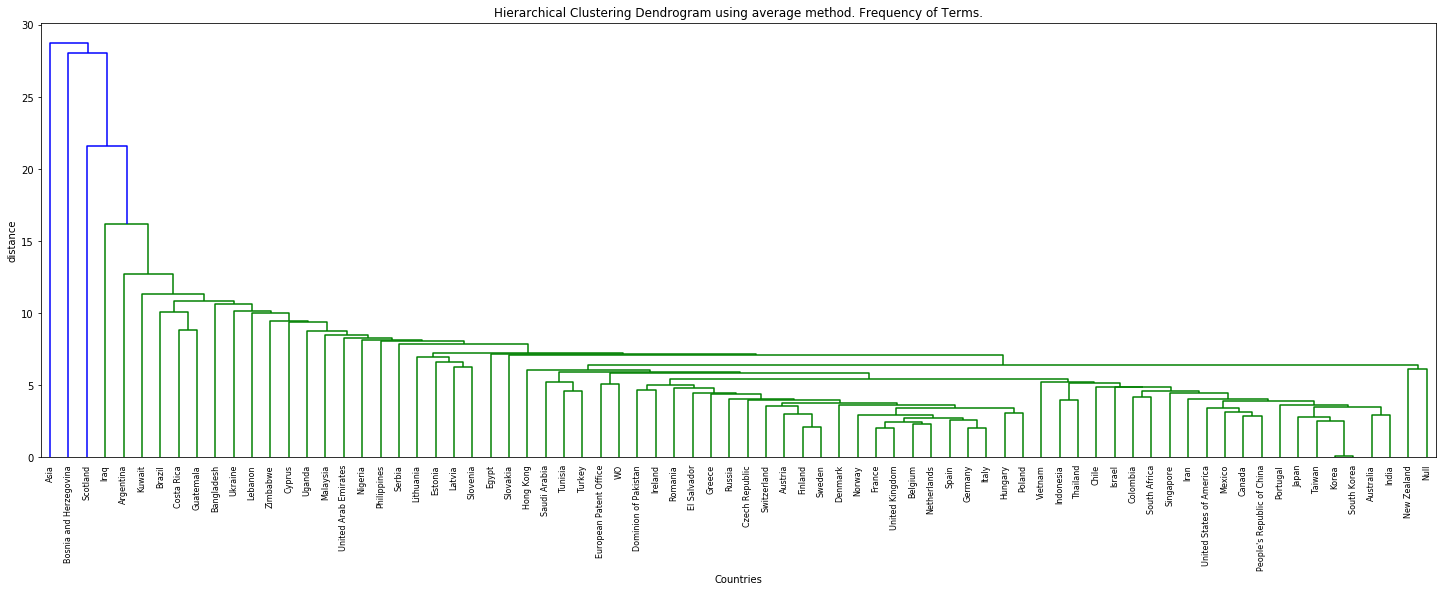

Cluster of Denmark:
[u'Austria', u'Belgium', u'Czech Republic', u'Denmark', u'El Salvador', u'Finland', u'France', u'Germany', u'Greece', u'Hungary', u'Italy', u'Netherlands', u'Norway', u'Poland', u'Russia', u'Spain', u'Sweden', u'Switzerland', u'United Kingdom']


In [43]:
# plot for the simple term frequency
matrix = numpy.delete(X, to_delete, 0)
labels = list(numpy.delete(country_names, to_delete))

name = 'Frequency of Terms.'

Z = plot_dendogram(matrix=matrix, labels=labels, method=method, name=name)
print 'Cluster of {}:'.format(country_of_interest)
print return_cluster(dendogram=Z, country_of_interest=country_of_interest, max_group_size=group_size, labels=labels)